# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 15, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 15,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 100,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [4096, 2048, 1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 100,
                
        'interpretation_net_output_monomials': 15, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 60,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': False,
        'n_jobs': 30,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 816
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  12255


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense4096-2048-1024-512-output_12255_drop0e2000b256_custom/lnets_100_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_100_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


2021-11-01 23:07:32.102254: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed: 12.9min finished
[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    4.8s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
83  1373158606                   0.000                   0.000   
53  1373158606                   0.000                   0.000   
70  1373158606                   0.000                   0.000   
45  1373158606                   0.000                   0.000   
44  1373158606                   0.000                   0.000   

    201000000000000-target  200100000000000-target  200010000000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200001000000000-target  200000100000000-target  200000010000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200000001000000-target  200000000100000-target  200000000010000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200000000001000-target  200000000000100-target  200000000000010-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                  -0.969   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200000000000001-target  200000000000000-target  120000000000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.442                   0.000   

    111000000000000-target  110100000000000-target  110010000000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.322                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    110001000000000-target  110000100000000-target  110000010000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    110000001000000-target  110000000100000-target  110000000010000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  300000000000000-target  210000000000000-target  \
count        100.000                 100.000                 100.000   
mean  1373158606.000                   0.002                  -0.005   
std            0.000                   0.015                   0.124   
min   1373158606.000                   0.000                  -0.956   
25%   1373158606.000                   0.000                   0.000   
50%   1373158606.000                   0.000                   0.000   
75%   1373158606.000                   0.000                   0.000   
max   1373158606.000                   0.154                   0.725   

       201000000000000-target  200100000000000-target  200010000000000-target  \
count                 100.000                 100.000                 100.000   
mean                    0.000                  -0.001                  -0.009   
std                     0.000                   0.008                   0.090   
min                     0.000                  -0.078                  -0.904   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
count                 100.000                 100.000                 100.000   
mean                    0.000                   0.007                   0.002   
std                     0.000                   0.085                   0.021   
min                     0.000                  -0.162                   0.000   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.000                   0.831                   0.212   

       200000001000000-target  200000000100000-target  200000000010000-target  \
count                 100.000                 100.000                 100.000   
mean                   -0.007                   0.003                   0.002   
std                     0.128                   0.031                   0.020   
min                    -0.907                   0.000                   0.000   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.612                   0.307                   0.201   

       200000000001000-target  200000000000100-target  200000000000010-target  \
count                 100.000                 100.000                 100.000   
mean                   -0.004                   0.003                  -0.007   
std                     0.100                   0.026                   0.148   
min                    -0.867                   0.000                  -0.969   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.481                   0.257                   0.918   

       200000000000001-target  200000000000000-target  120000000000000-target  \
count                 100.000                 100.000                 100.000   
mean                   -0.014                   0.013                  -0.005   
std                     0.096                   0.100                   0.046   
min                    -0.792                   0.000                  -0.461   
25%                     0.000             

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.91272915, 0.95326139, 0.91240973, 0.16042798, 0.09785271,
        0.75416719, 0.62055045, 0.82320564, 0.33475479, 0.33135975,
        0.44866029, 0.85936497, 0.97274054, 0.49862374, 0.29626734],
       [0.86948343, 0.63207831, 0.48955421, 0.14681686, 0.89388112,
        0.35683774, 0.67585271, 0.78010885, 0.57858367, 0.90178433,
        0.92405949, 0.6691673 , 0.11575074, 0.79445642, 0.27355943],
       [0.51747874, 0.28508965, 0.90481911, 0.48746268, 0.06800388,
        0.76086051, 0.95536664, 0.3317016 , 0.66087987, 0.03026095,
        0.99000349, 0.19028188, 0.84813466, 0.46082114, 0.26387408],
       [0.48206076, 0.19130905, 0.52371153, 0.50753521, 0.10563502,
        0.97187207, 0.58342218, 0.11573744, 0.57010867, 0.79801254,
        0.6210655 , 0.16035848, 0.96834744, 0.88325712, 0.73932814],
       [0.18750963, 0.71235299, 0.80346706, 0.0290474 , 0.01256971,
        0.67450104, 0.68626206, 0.66772732, 0.32386959, 0.02331027,
        0.18430294, 0.34245682, 0.98710679, 

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-1.86146748],
       [-1.52714598],
       [-1.49249315],
       [-1.51688492],
       [-1.13969946],
       [-0.73279184],
       [-0.94914043],
       [-0.84748822],
       [-1.09199536],
       [-0.63337529]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            lambda_net_test_dataset = lambda_net_dataset #_, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 3725)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 3725)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3725)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
15722  1373158606                   0.000                   0.000   
49742  1373158606                   0.000                   0.000   
15559  1373158606                   0.000                   0.000   
37857  1373158606                   0.000                   0.000   
35691  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                  -0.524   
35691                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.0

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
35587  1373158606                   0.292                   0.000   
32681  1373158606                   0.000                   0.000   
40971  1373158606                   0.000                   0.000   
21022  1373158606                   0.000                   0.000   
6403   1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.894                   0.000   
6403                    0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.034                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.0

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
83  1373158606                   0.000                   0.000   
53  1373158606                   0.000                   0.000   
70  1373158606                   0.000                   0.000   
45  1373158606                   0.000                   0.000   
44  1373158606                   0.000                   0.000   

    201000000000000-target  200100000000000-target  200010000000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200001000000000-target  200000100000000-target  200000010000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200000001000000-target  200000000100000-target  200000000010000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200000000001000-target  200000000000100-target  200000000000010-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                  -0.969   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    200000000000001-target  200000000000000-target  120000000000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.442                   0.000   

    111000000000000-target  110100000000000-target  110010000000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.322                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    110001000000000-target  110000100000000-target  110000010000000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                   0.000                   0.000                   0.000   
44                   0.000                   0.000                   0.000   

    110000001000000-target  110000000100000-target  110000000010000-target  \
83                   0.000                   0.000                   0.000   
53                   0.000                   0.000                   0.000   
70                   0.000                   0.000                   0.000   
45                

## Interpretation Network Training

In [23]:
#%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(1276,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Training Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01


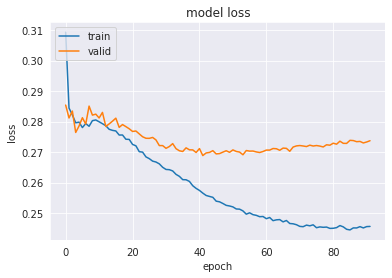

In [25]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1276)]       0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         5230592     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  
runtimes_list = []

for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)
    runtimes_list.append({})
    



In [28]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred, inet_runtime = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred
    runtimes_list[i]['inet_runtime'] =  np.array([inet_runtime/len(lambda_net_test_dataset.target_polynomial_list) for _ in range(len(lambda_net_test_dataset.target_polynomial_list))])
    

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [29]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test     
        runtimes_list[i]['metamodel_poly_runtime'] = metamodel_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       
        runtimes_list[i]['metamodel_functions_runtime'] = metamodel_runtimes
        
    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
2021-11-01 23:23:56.743978: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 23:23:56.747006: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 23:23:56.753881: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 23:23:56.794819: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 23:23:56.798339: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 23:23:56.811177: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERR


None

None

None

None

None

None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 226, in loss_grads
    loss_grad_b = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[1])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep


None

None

None

None

None

None

None

None

None

None

None

None

None

None

None

None

None


_man_exp(n, 0, prec, rnd)
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/mpmath/libmp/libmpf.py", line 310, in from_man_exp
    if not t:
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise exception
RuntimeError
  0%|          | 0/15 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 270, in fit
    self.exact_expression, self.approx_expression = self.symbolic_expression()
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 317, in symbolic_expression
    sym_exact  += sympify(str(self.init_model.coef_[v] * re(f_curr.expres


None


 60%|██████    | 6/10 [28:26<18:57, 284.41s/it][Parallel(n_jobs=30)]: Done  38 tasks      | elapsed: 113.0min

Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in fit
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in <listcomp>
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamode


None


 60%|██████    | 6/10 [31:45<21:10, 317.65s/it][Parallel(n_jobs=30)]: Done  39 tasks      | elapsed: 113.1min

Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/core/assumptions.py", line 454, in getit
    return self._assumptions[fact]
KeyError: 'zero'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/core/assumptions.py", line 454, in getit
    return self._assumptions[fact]
KeyError: 'extended_nonpositive'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/core/assumptions.py", line 454, in getit
    return self._assumptions[fact]
KeyError: 'extended_positive'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File


None


 60%|██████    | 6/10 [33:01<22:01, 330.31s/it][Parallel(n_jobs=30)]: Done  40 tasks      | elapsed: 113.8min

Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 270, in fit
    self.exact_expression, self.approx_expression = self.symbolic_expression()
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 318, in symbolic_expression
    sym_approx += sympify(str(self.init_model.coef_[v] * re(f_curr.approx_expression()))).subs(x, dims_[v])
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/models/special_functions.py", line 114, in approx_expression
    self.Taylor_poly_ = taylor(self.math_expr, midpoint, self.approximati


None


 50%|█████     | 5/10 [26:14<26:14, 314.94s/it]


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in fit
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in <listcomp>
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 233, in loss_grad_coeff
    loss_grad_ = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x)
  


None


 33%|███▎      | 5/15 [07:08<12:50, 77.09s/it]]


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 225, in loss_grads
    loss_grad_a = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[0])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep


None

None

None

None

None

None

None

None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 226, in loss_grads
    loss_grad_b = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[1])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep


None

None

None

None

None

None

None

None


on3.8/site-packages/mpmath/calculus/differentiation.py", line 275, in diffs
    yield f(ctx.convert(x))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/models/special_functions.py", line 105, in math_expr
    return mp.meijerg(a_p_, b_q_, self._const * x)
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/mpmath/functions/hypergeometric.py", line 1058, in meijerg
    return ctx.hypercomb(h, a+b, **kwargs)
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/mpmath/functions/hypergeometric.py", line 125, in hypercomb
    v = ctx.fprod([ctx.hyper(a_s, b_s, z, **kwargs)] + \
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/mpmath/functions/hypergeometric.py", line 226, in hyper
    if   q == 1: return ctx._hyp2f1(a_s, b_s, z, **kwargs)
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/mpmath/functions/hypergeometric.py", line 473, in _hyp2f1
    v = _hyp2f1_gosper(ctx,a,b,c,z,**kwargs)
  File "


None


 70%|███████   | 7/10 [33:35<14:23, 287.89s/it]
Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 226, in loss_grads
    loss_grad_b = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[1])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__


None


100%|██████████| 10/10 [39:23<00:00, 236.30s/it] 


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in fit
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in <listcomp>
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 233, in loss_grad_coeff
    loss_grad_ = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x)
  


None


 40%|████      | 6/15 [08:26<10:51, 72.41s/it]]]


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 245, in fit
    self.params[u, :] = tune_single_dim(lr=0.1, n_iter=500, x=self.X_new[:, u], y=self.Y_r, verbosity=self.verbosity)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 122, in tune_single_dim
    func_true   = basis(a, b, c, x[batch_index])
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 62, in basis
    return func_.evaluate(x + epsilon)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/models/special_functions.py", line 142, in evaluate
    'cython': lambdify([x], self.approx_expression


None


100%|██████████| 15/15 [21:11<00:00, 84.77s/it]


None



Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/core/assumptions.py", line 454, in getit
    return self._assumptions[fact]
KeyError: 'zero'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/core/assumptions.py", line 454, in getit
    return self._assumptions[fact]
KeyError: 'extended_positive'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/core/assumptions.py", line 454, in getit
    return self._assumptions[fact]
KeyError: 'zero'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
   


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 245, in fit
    self.params[u, :] = tune_single_dim(lr=0.1, n_iter=500, x=self.X_new[:, u], y=self.Y_r, verbosity=self.verbosity)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 122, in tune_single_dim
    func_true   = basis(a, b, c, x[batch_index])
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 62, in basis
    return func_.evaluate(x + epsilon)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/models/special_functions.py", line 141, in evaluate
    evaluators_ = {'numpy': lambdify([x], self.app


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 225, in loss_grads
    loss_grad_a = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[0])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 225, in loss_grads
    loss_grad_a = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[0])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in fit
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 265, in <listcomp>
    coef_grads            = [self.loss_grad_coeff(self.Y_r[batch_index], curr_func, self.X_init[batch_index, k]) for k in range(self.X_init.shape[1])]
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 233, in loss_grad_coeff
    loss_grad_ = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x)
  


None


 93%|█████████▎| 14/15 [18:13<01:03, 63.43s/it]
Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 225, in loss_grads
    loss_grad_a = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[0])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__


None


tion
RuntimeError



None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 245, in fit
    self.params[u, :] = tune_single_dim(lr=0.1, n_iter=500, x=self.X_new[:, u], y=self.Y_r, verbosity=self.verbosity)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 122, in tune_single_dim
    func_true   = basis(a, b, c, x[batch_index])
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 62, in basis
    return func_.evaluate(x + epsilon)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/models/special_functions.py", line 143, in evaluate
    'theano': lambdify([x], self.approx_expression


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 270, in fit
    self.exact_expression, self.approx_expression = self.symbolic_expression()
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 317, in symbolic_expression
    sym_exact  += sympify(str(self.init_model.coef_[v] * re(f_curr.expression()))).subs(x, dims_[v])
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/models/special_functions.py", line 92, in expression
    self.expr = hyperexpand(meijerg(self.a_p, self.b_q, self._const * x))
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sympy/simplify/hyperexpand.py", line 2513, in hyperexpa


None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 226, in loss_grads
    loss_grad_b = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[1])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep


None

None



Traceback (most recent call last):
  File "/work-ceph/smarton/InES_XAI/02_polynomials/utilities/utility_functions.py", line 1964, in symbolic_metamodeling_original
    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'],
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 262, in fit
    param_grads  = self.get_gradients(self.Y_r[batch_index], curr_func, batch_index)
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 214, in get_gradients
    param_grads[k, :] = np.array(self.loss_grads(Y_true, Y_metamodel, grads_vals))
  File "/work-ceph/smarton/InES_XAI/02_polynomials/pysymbolic_original/algorithms/symbolic_metamodeling.py", line 225, in loss_grads
    loss_grad_a = np.mean(2 * (Y_true - Y_metamodel) * param_grads_x[0])
  File "/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/interruptingcow/__init__.py", line 74, in handler
    raise excep

Metamodel Optimization Time: 3:34:38
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed: 214.6min finished


In [31]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test   
        runtimes_list[i]['metamodel_functions_no_GD_runtime'] = metamodel_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [32]:
%load_ext autoreload

In [33]:
%autoreload 2
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test, symbolic_regression_runtimes = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test    
        runtimes_list[i]['symbolic_regression_runtime'] = symbolic_regression_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------
TIMEOUT


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
2021-11-02 02:58:36.775051: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 02:58:36.781105: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 02:58:36.786564: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 02:58:36.794999: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 02:58:36.801550: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 02:58:36.803683: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERR

Symbolic Regression Optimization Time: 0:11:09
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed: 11.2min finished


In [34]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [35]:
#%load_ext autoreload

In [36]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


False


[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=30)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions


[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=30)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:01:35
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    1.2s finished


In [37]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []
runtime_distrib_list = []
for function_values_test, polynomial_dict_test, runtimes_dict in zip(function_values_test_list, polynomial_dict_test_list, runtimes_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)
    runtimes_list.append(pd.DataFrame(runtimes_dict))

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_metamodel_functions
lambda_preds_VS_symbolic_regression_functions
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_metamodel_functions
target_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_metamodel_functions
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_target_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_metamodel_functions
lstsq_target_polynomials_VS_symbolic_regression_functions
inet_polynomials_VS_metamodel_fu

In [38]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [39]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [40]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1276)]       0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         5230592     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [41]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [42]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [43]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_metamodel_functions                  NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.081 0.110  7.484   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.227 0.312 21.983   
target_polynomials_VS_metamodel_functions            NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.081 0.110  2.179   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.235 0.316 16.623   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.227 0.312 21.983   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.402   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.154   
target_polynomials_VS_metamodel_functions                NaN   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.402   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.137   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.154   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_metamodel_functions                  NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
metamodel_functions_VS_symbolic_regression_func...       NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_metamodel_functions                                 NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_metamodel_functions                           NaN   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials             

In [44]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_metamodel_functions                  NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.081 0.110  7.484   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.227 0.312 21.983   
target_polynomials_VS_metamodel_functions            NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.081 0.110  2.179   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.235 0.316 16.623   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.227 0.312 21.983   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.402   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.154   
target_polynomials_VS_metamodel_functions                NaN   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.402   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.137   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.154   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_metamodel_functions                  NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
metamodel_functions_VS_symbolic_regression_func...       NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_metamodel_functions                                 NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_metamodel_functions                           NaN   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials             

In [45]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.042 0.053 0.050 0.054   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.057 0.068 0.068 0.062   
lambda_preds_VS_lstsq_target_polynomials           0.042 0.053 0.050 0.054   
lambda_preds_VS_inet_polynomials                   0.335 0.267 0.384 0.204   
lambda_preds_VS_metamodel_functions                  NaN   NaN   NaN   NaN   
lambda_preds_VS_symbolic_regression_functions      0.150 0.202 0.199 0.135   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.057 0.067 0.072 0.066   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.336 0.269 0.383 0.208   
target_polynomials_VS_metamodel_functions            NaN   NaN   NaN   NaN   
target_polynomials_VS_symbolic_regression_funct... 0.150 0.207 0.203 0.137   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.057 0.067 0.072 0.066   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.339 0.271 0.390 0.210   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN   NaN   NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.157 0.208 0.205 0.149   
lstsq_target_polynomials_VS_inet_polynomials       0.336 0.269 0.383 0.208   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN   NaN   NaN   
lstsq_target_polynomials_VS_symbolic_regression... 0.150 0.207 0.203 0.137   
inet_polynomials_VS_metamodel_functions              NaN   NaN   NaN   NaN   
inet_polynomials_VS_symbolic_regression_functions  0.348 0.190 0.347 0.177   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN   NaN   NaN   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.038 0.043 0.042 0.046   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.060 0.060 0.053 0.061   
lambda_preds_VS_lstsq_target_polynomials           0.038 0.043 0.042 0.046   
lambda_preds_VS_inet_polynomials                   0.268 0.407 0.248 0.290   
lambda_preds_VS_metamodel_functions                  NaN 0.506 0.754   NaN   
lambda_preds_VS_symbolic_regression_functions      0.215 0.239 0.201 0.232   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.057 0.061 0.057 0.064   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.271 0.403 0.249 0.296   
target_polynomials_VS_metamodel_functions            NaN 0.515 0.753   NaN   
target_polynomials_VS_symbolic_regression_funct... 0.218 0.241 0.201 0.234   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.057 0.061 0.057 0.064   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.273 0.411 0.257 0.298   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN 0.512 0.751   NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.221 0.248 0.209 0.238   
lstsq_target_polynomials_VS_inet_polynomials       0.271 0.403 0.249 0.296   
lstsq_target_polynomials_VS_metamodel_functions      NaN 0.515 0.753   NaN   
lstsq_target_polynomials_VS_symbolic_regression... 0.218 0.241 0.201 0.234   
inet_polynomials_VS_metamodel_functions              NaN 0.686 0.783   NaN   
inet_polynomials_VS_symbolic_regression_functions  0.242 0.367 0.223 0.306   
metamodel_functions_VS_symbolic_regression_func...   NaN 0.541 0.726   NaN   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.052 0.039 0.043 0.045   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.063 0.060 0.064 0.061   
lambda_preds_VS_lstsq_target_polynomials           0.052 0.039 0.043 0.045   
lambda_preds_VS_inet_polynomials                   0.293 0.340 0.332 0.167   
lambda_preds_VS_metamodel_functions                  NaN   NaN   NaN   NaN   
lambda_preds_VS_symbolic_regression_functions      0.227 0.212 0.175 0.181   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.067 0.057 0.060 0.06

In [46]:
distrib_dict_test_list[-1]['R2']

L-0    L-1    L-2    L-3  \
lambda_preds_VS_target_polynomials                 0.988  0.963  0.970  0.949   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.980  0.943  0.947  0.941   
lambda_preds_VS_lstsq_target_polynomials           0.988  0.963  0.970  0.949   
lambda_preds_VS_inet_polynomials                   0.323  0.149 -0.511  0.331   
lambda_preds_VS_metamodel_functions                  NaN    NaN    NaN    NaN   
lambda_preds_VS_symbolic_regression_functions      0.858  0.516  0.553  0.715   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.980  0.949  0.942  0.936   
target_polynomials_VS_lstsq_target_polynomials     1.000  1.000  1.000  1.000   
target_polynomials_VS_inet_polynomials             0.332  0.152 -0.456  0.326   
target_polynomials_VS_metamodel_functions            NaN    NaN    NaN    NaN   
target_polynomials_VS_symbolic_regression_funct... 0.860  0.500  0.542  0.725   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.980  0.948  0.941  0.935   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.314  0.151 -0.525  0.329   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN    NaN    NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.845  0.503  0.535  0.680   
lstsq_target_polynomials_VS_inet_polynomials       0.332  0.152 -0.456  0.326   
lstsq_target_polynomials_VS_metamodel_functions      NaN    NaN    NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression... 0.860  0.500  0.542  0.725   
inet_polynomials_VS_metamodel_functions              NaN    NaN    NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions  0.183 -3.855 -0.654 -0.445   
metamodel_functions_VS_symbolic_regression_func...   NaN    NaN    NaN    NaN   

                                                      L-4     L-5     L-6  \
lambda_preds_VS_target_polynomials                  0.980   0.986   0.980   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.957   0.973   0.969   
lambda_preds_VS_lstsq_target_polynomials            0.980   0.986   0.980   
lambda_preds_VS_inet_polynomials                    0.137  -0.236   0.377   
lambda_preds_VS_metamodel_functions                   NaN  -0.486  -3.267   
lambda_preds_VS_symbolic_regression_functions       0.462   0.582   0.568   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.962   0.973   0.965   
target_polynomials_VS_lstsq_target_polynomials      1.000   1.000   1.000   
target_polynomials_VS_inet_polynomials              0.141  -0.215   0.359   
target_polynomials_VS_metamodel_functions             NaN  -0.491  -3.230   
target_polynomials_VS_symbolic_regression_funct...  0.470   0.579   0.559   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.961   0.973   0.966   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.132  -0.218   0.353   
lstsq_lambda_pred_polynomials_VS_metamodel_func...    NaN  -0.470  -3.106   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.452   0.566   0.544   
lstsq_target_polynomials_VS_inet_polynomials        0.141  -0.215   0.359   
lstsq_target_polynomials_VS_metamodel_functions       NaN  -0.491  -3.230   
lstsq_target_polynomials_VS_symbolic_regression...  0.470   0.579   0.559   
inet_polynomials_VS_metamodel_functions               NaN -28.388  -9.500   
inet_polynomials_VS_symbolic_regression_functions  -0.788 -11.200  -0.271   
metamodel_functions_VS_symbolic_regression_func...    NaN -26.569 -69.791   

                                                      L-7    L-8    L-9  \
lambda_preds_VS_target_polynomials                  0.979  0.975  0.986   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.963  0.964  0.967   
lambda_preds_VS_lstsq_target_polynomials            0.979  0.975  0.986   
lambda_preds_VS_inet_polynomials                    0.232  0.300 -0.016   
lambda_preds_VS_metamodel_functions                   NaN    NaN    NaN   
lambda_preds_VS_symbolic_regression_functions       0.504  0.571  0.618   
target_polynomials_VS_lstsq_lambda_pred_polynom...

In [47]:
runtimes_list[-1]

inet_runtime  metamodel_functions_runtime  symbolic_regression_runtime
0          0.004                          NaN                      324.083
1          0.004                          NaN                      103.657
2          0.004                          NaN                      122.797
3          0.004                          NaN                      205.053
4          0.004                          NaN                      163.715
..           ...                          ...                          ...
95         0.004                     2868.786                      122.043
96         0.004                     2830.135                      107.254
97         0.004                     2697.616                      148.311
98         0.004                     2759.933                      111.961
99         0.004                     2598.545                       79.954

[100 rows x 3 columns]

In [48]:
paths_dict = generate_paths(path_type = 'interpretation_net_no_noise')

path_mae = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/mae_distrib_test_data_' + 'noise' + str(noise) + '.csv'
path_r2 = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/r2_distrib_test_data_' + 'noise' + str(noise) + '.csv'
path_runtimes = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/runtimes_' + 'noise' + str(noise) + '.csv'
path_fv = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/fvs_' + 'noise' + str(noise) + '.csv'
path_functions = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/functions_' + 'noise' + str(noise) + '.csv'


distrib_dict_test_list[-1]['MAE'].to_csv(path_mae)
distrib_dict_test_list[-1]['R2'].to_csv(path_r2)
runtimes_list[-1].to_csv(path_runtimes)

with open(path_fv, 'wb') as f:
    pickle.dump(function_values_test_list[-1], f, protocol=2)

with open(path_functions, 'wb') as f:
    pickle.dump(polynomial_dict_test_list[-1], f, protocol=2)


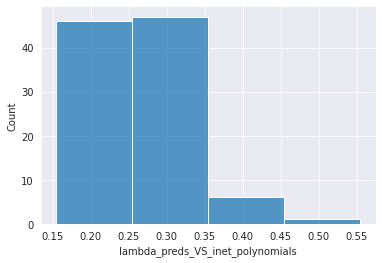

In [49]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

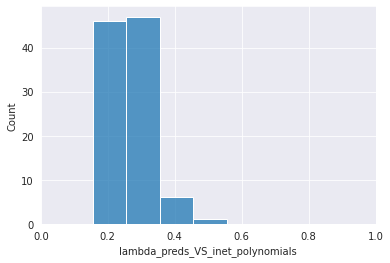

In [50]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


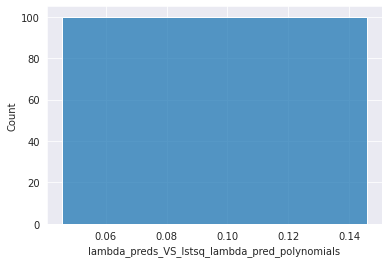

In [51]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

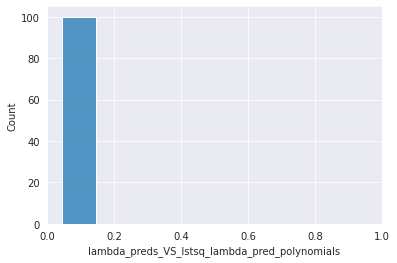

In [52]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


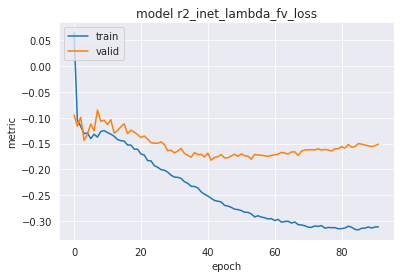

In [53]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


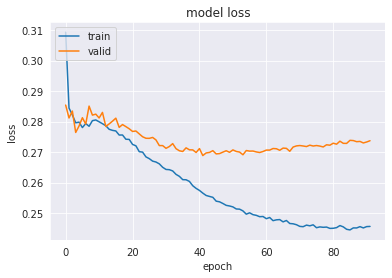

In [54]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [55]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [56]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [57]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [ ]:
84 92 94 96

In [83]:
index = 92

custom_representation_keys_fixed = ['target_polynomials']#['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions', 'symbolic_regression_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    if key in custom_representation_keys_fixed:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)        
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in sympy_representation_keys:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        display(polynomial_dict_test_list[-1][key][index])
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
    else:
        pass

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.4247*a*e*n - 0.0071*b*c*j + 0.4567*b*c*o + 0.3305*b*f*o + 0.7509*d**2*i - 0.0932*d**2 + 0.2249*d*e*h + 0.1848*d*k*m - 0.4626*e*l*n - 0.6426*e*m**2 - 0.132*f*g*h + 0.9694*f*h*l + 0.5357*f*h*m - 0.1638*f*h*o + 0.7456*i*n*o

MAE:  0.037164588
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.0722000002861023*a**3 + 0.657400012016296*a*c*i + 0.0555000007152557*a*h*n + 0.0763999968767166*a*k + 0.14360000193119*b**2*d - 0.0359000004827976*c*d - 0.176400005817413*c*j*n + 0.218199998140335*c*n*o + 0.517599999904633*d**2*l + 0.0368999987840652*e + 0.165299996733665*g*h*m - 0.0551999993622303*g*m*o + 0.225199997425079*h*i*j + 0.216600000858307*j*k*o + 0.197899997234344*j*l*o

MAE:  0.19708037
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
metamodel_functions


1/(1.22895742034042*exp(0.000520959593885445*X0**3*X1**3 - 0.00138653496110204*X0**3*X10**3 - 0.00149256728936525*X0**3*X11**3 - 0.00287603012967762*X0**3*X12**3 + 0.0179505902992759*X0**3*X13**3 - 0.00149098370577911*X0**3*X14**3 - 0.00173656274075231*X0**3*X2**3 - 0.00182586038180477*X0**3*X3**3 + 0.0191719897736112*X0**3*X4**3 - 0.00396633126898772*X0**3*X5**3 + 0.00204771536612441*X0**3*X6**3 - 0.00354625111769148*X0**3*X7**3 - 0.00579237672429915*X0**3*X8**3 - 0.000276222283489732*X0**3*X9**3 - 0.0169513112940274*X0**3 - 0.00026309004290595*X0**2*X1**2 + 0.000605967125237756*X0**2*X10**2 + 0.000735144220596684*X0**2*X11**2 + 0.00103513804103506*X0**2*X12**2 - 0.00932362521663298*X0**2*X13**2 + 0.000823765982840261*X0**2*X14**2 + 0.000831144782730945*X0**2*X2**2 + 0.00100549461382999*X0**2*X3**2 - 0.00826670985291639*X0**2*X4**2 + 0.00214522815049507*X0**2*X5**2 - 0.000887956757528216*X0**2*X6**2 + 0.0019416599980412*X0**2*X7**2 + 0.00325259358915034*X0**2*X8**2 + 0.000124101149659

MAE:  0.2377252
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


X1*X5*X7*(X11 + X14) + X3*X8

MAE:  0.14978991
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [84]:
from sympy import Number
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

print('Target Poly: ', get_sympy_string_from_coefficients(polynomial_dict_test_list[-1]['target_polynomials'][index], force_complete_poly_representation=True, round_digits=4))
print('Inet Poly: ', str(get_sympy_string_from_coefficients(polynomial_dict_test_list[-1]['inet_polynomials'][index], round_digits=4)))
print('SM Function: ', str(round_expr(polynomial_dict_test_list[-1]['metamodel_functions'][index], 4)))
print('SR Function: ', str(round_expr(polynomial_dict_test_list[-1]['symbolic_regression_functions'][index], 4)))


Target Poly:  0.4247*a*e*n - 0.0071*b*c*j + 0.4567*b*c*o + 0.3305*b*f*o + 0.7509*d**2*i - 0.0932*d**2 + 0.2249*d*e*h + 0.1848*d*k*m - 0.4626*e*l*n - 0.6426*e*m**2 - 0.132*f*g*h + 0.9694*f*h*l + 0.5357*f*h*m - 0.1638*f*h*o + 0.7456*i*n*o
Inet Poly:  0.0722000002861023*a**3 + 0.657400012016296*a*c*i + 0.0555000007152557*a*h*n + 0.0763999968767166*a*k + 0.14360000193119*b**2*d - 0.0359000004827976*c*d - 0.176400005817413*c*j*n + 0.218199998140335*c*n*o + 0.517599999904633*d**2*l + 0.0368999987840652*e + 0.165299996733665*g*h*m - 0.0551999993622303*g*m*o + 0.225199997425079*h*i*j + 0.216600000858307*j*k*o + 0.197899997234344*j*l*o
SM Function:  1/(1.229*exp(0.0005*X0**3*X1**3 - 0.0014*X0**3*X10**3 - 0.0015*X0**3*X11**3 - 0.0029*X0**3*X12**3 + 0.018*X0**3*X13**3 - 0.0015*X0**3*X14**3 - 0.0017*X0**3*X2**3 - 0.0018*X0**3*X3**3 + 0.0192*X0**3*X4**3 - 0.004*X0**3*X5**3 + 0.002*X0**3*X6**3 - 0.0035*X0**3*X7**3 - 0.0058*X0**3*X8**3 - 0.0003*X0**3*X9**3 - 0.017*X0**3 - 0.0003*X0**2*X1**2 + 0.0006*

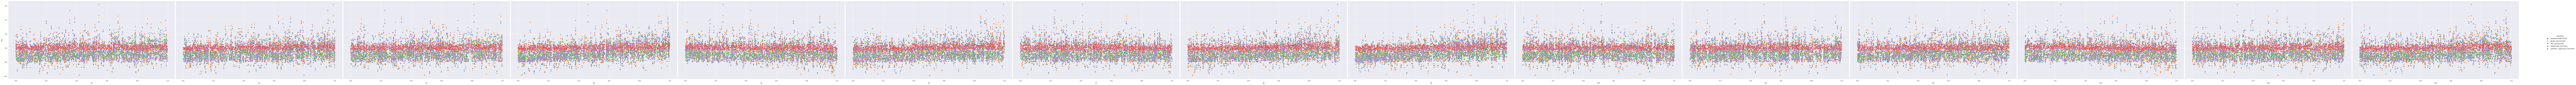

In [85]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [86]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

LinAlgError: Singular matrix

ValueError: 'bboxes' cannot be empty

<Figure size 0x0 with 256 Axes>

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [74]:
runtimes_list[-1].values[:,1]

array([          nan,           nan,           nan,           nan,
                 nan, 3589.47970557, 3210.57601452,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 3008.00089765,           nan,
       3161.50669527,           nan,           nan, 3474.99811649,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 3423.67554879,           nan,
       3168.81700182,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
       2801.88896632,           nan,           nan,           nan,
       2990.95771408,           nan,           nan, 2757.6429987 ,
       2920.96179056,           nan, 2830.03704238,           nan,
                 nan, 3310.33574176,           nan,           nan,
                 nan,           nan, 2783.85351753,           

In [75]:
runtimes_list[-1].values[:,2]

array([324.08329391, 103.65675831, 122.79662991, 205.05301309,
       163.71526527, 103.84115791, 112.54312158, 145.12351131,
       208.30635524,  81.57103419, 185.48500752, 123.30268049,
        88.16771078, 136.40396833, 142.47797179,  70.49329114,
        85.24658608, 138.72693753, 191.66861391, 154.18364096,
       206.31761622, 116.55607748,  69.46999049, 296.34370351,
       127.92749023, 151.28734779, 157.49983621, 125.05052471,
       146.76972389, 229.83665466, 172.72496772, 136.77294755,
       146.10409188, 260.4853518 , 132.67402649, 520.23277116,
       279.53348994, 168.5197432 , 212.91822791, 135.93733954,
       336.32705712, 261.40349364,  93.69895911, 126.55102491,
       124.3234911 , 135.0097506 , 146.96943831, 136.44216061,
        69.57780695, 357.26528168, 126.49648213, 106.39691234,
       139.84292674, 252.91717362,  77.1798234 , 221.88426733,
       238.00481796, 158.56145811, 185.73881531, 150.36196089,
       121.09181738, 129.557055  , 303.36144066, 152.82

In [61]:
runtimes_list[-1].values

array([[3.52100611e-03,            nan, 3.24083294e+02],
       [3.52100611e-03,            nan, 1.03656758e+02],
       [3.52100611e-03,            nan, 1.22796630e+02],
       [3.52100611e-03,            nan, 2.05053013e+02],
       [3.52100611e-03,            nan, 1.63715265e+02],
       [3.52100611e-03, 3.58947971e+03, 1.03841158e+02],
       [3.52100611e-03, 3.21057601e+03, 1.12543122e+02],
       [3.52100611e-03,            nan, 1.45123511e+02],
       [3.52100611e-03,            nan, 2.08306355e+02],
       [3.52100611e-03,            nan, 8.15710342e+01],
       [3.52100611e-03,            nan, 1.85485008e+02],
       [3.52100611e-03,            nan, 1.23302680e+02],
       [3.52100611e-03,            nan, 8.81677108e+01],
       [3.52100611e-03,            nan, 1.36403968e+02],
       [3.52100611e-03, 3.00800090e+03, 1.42477972e+02],
       [3.52100611e-03,            nan, 7.04932911e+01],
       [3.52100611e-03, 3.16150670e+03, 8.52465861e+01],
       [3.52100611e-03,        

In [62]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

array([0.33507627, 0.2671199 , 0.38435775, 0.2044917 , 0.26790082,
       0.40670532, 0.24794511, 0.29009774, 0.29287133, 0.34000623,
       0.33229262, 0.1674218 , 0.281208  , 0.27623886, 0.37491566,
       0.2157167 , 0.23146416, 0.24487847, 0.18243162, 0.21398877,
       0.30185014, 0.18225594, 0.32152975, 0.29262206, 0.19952118,
       0.23240489, 0.2214128 , 0.2033533 , 0.20822537, 0.25199077,
       0.34685436, 0.25899598, 0.2670699 , 0.39592224, 0.19070458,
       0.25195444, 0.3002055 , 0.19571608, 0.25532597, 0.168296  ,
       0.25908148, 0.29601458, 0.25596693, 0.33626974, 0.37070146,
       0.24925117, 0.19886681, 0.24075401, 0.27207565, 0.20632632,
       0.25385135, 0.33732188, 0.22405192, 0.29423404, 0.2358563 ,
       0.26612133, 0.15463711, 0.33596018, 0.27044404, 0.33037797,
       0.467955  , 0.30536157, 0.3072717 , 0.21315764, 0.2646643 ,
       0.20181324, 0.3354997 , 0.27820274, 0.20567574, 0.3111662 ,
       0.24475607, 0.25625902, 0.26696378, 0.21673453, 0.32871

In [70]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_symbolic_regression_functions'].values

array([0.1501856 , 0.20214629, 0.19943133, 0.13494109, 0.21485771,
       0.23876919, 0.20144507, 0.23170334, 0.2271542 , 0.21225747,
       0.17533004, 0.18054028, 0.21282692, 0.22655894, 0.2560459 ,
       0.17592563, 0.21605586, 0.23449668, 0.11335879, 0.21865802,
       0.18986738, 0.1761267 , 0.16005713, 0.20013347, 0.22435096,
       0.2458355 , 0.2443312 , 0.19757989, 0.14318633, 0.19577509,
       0.17465486, 0.18194287, 0.23646614, 0.27448773, 0.15834744,
       0.14856318, 0.21438877, 0.16699694, 0.17960747, 0.16965723,
       0.16137475, 0.2071544 , 0.20690745, 0.23526216, 0.2666185 ,
       0.22211109, 0.16309623, 0.16907966, 0.20132332, 0.15902081,
       0.18922292, 0.30343193, 0.20424479, 0.18925633, 0.21661709,
       0.17032206, 0.15434107, 0.25085562, 0.25235122, 0.22433159,
       0.24231488, 0.21133919, 0.20587958, 0.20411696, 0.1977873 ,
       0.20568419, 0.20704594, 0.28853512, 0.19854201, 0.14861329,
       0.17453733, 0.1445493 , 0.20997359, 0.22396468, 0.21634

In [64]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_metamodel_functions'].values

array([       nan,        nan,        nan,        nan,        nan,
       0.50551057, 0.75437605,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.9239797 ,
              nan, 0.8501016 ,        nan,        nan, 0.8347099 ,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.89222246,        nan, 0.5830597 ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.29633173,        nan,        nan,        nan, 0.92218554,
              nan,        nan, 0.6309009 , 0.390281  ,        nan,
       0.4522246 ,        nan,        nan, 0.542674  ,        nan,
              nan,        nan,        nan, 1.0734512 ,        nan,
              nan, 0.68924063, 0.7397402 ,        nan, 1.024836  ,
              nan, 0.42835438, 0.43967295,        nan,        nan,
              nan, 0.75372714,        nan, 0.3773441 , 0.95497

In [65]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([ 0.3234804 ,  0.14935385, -0.51077567,  0.33098392,  0.1366458 ,
       -0.23629279,  0.37742605,  0.23150317,  0.30040437, -0.01551755,
        0.21243488,  0.43975396,  0.19505283,  0.06666652,  0.04586857,
        0.05429525,  0.25237148,  0.51558068,  0.14075122,  0.3187773 ,
       -0.0855755 ,  0.10871916, -0.00721273,  0.35219236,  0.25663226,
        0.4671177 ,  0.52744488,  0.30762882,  0.03288417,  0.30341582,
       -0.10507509,  0.25652725,  0.32026384,  0.12946253,  0.31765   ,
        0.04337091,  0.07597907,  0.151161  ,  0.17533277,  0.15918949,
        0.19644836,  0.63871703,  0.25764898,  0.10547009,  0.12817018,
        0.1633858 ,  0.70223368, -0.13219033,  0.41501795,  0.37152895,
        0.40819548,  0.27731687,  0.48370504,  0.09288853,  0.29419238,
       -0.18336628,  0.28419381,  0.07766605,  0.48841892,  0.15613544,
        0.05362207,  0.14181712,  0.13043587,  0.35891733,  0.39008882,
        0.27151709,  0.15147522,  0.35653579,  0.33869165,  0.26

In [66]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_symbolic_regression_functions'].values

array([0.85815538, 0.51570275, 0.55318782, 0.71466272, 0.4619726 ,
       0.5821422 , 0.56811562, 0.50425491, 0.57064146, 0.61759109,
       0.7692009 , 0.36559275, 0.55270729, 0.35438432, 0.56201413,
       0.39945916, 0.29656908, 0.52836026, 0.66879728, 0.27716114,
       0.5781324 , 0.18192138, 0.7434346 , 0.70050466, 0.05515724,
       0.43577412, 0.41636814, 0.36627165, 0.54506456, 0.55222603,
       0.70112963, 0.61274721, 0.45596441, 0.57546706, 0.52902596,
       0.70325709, 0.51613318, 0.38827792, 0.59608533, 0.15177448,
       0.68510387, 0.82876764, 0.46661335, 0.53630435, 0.54985722,
       0.33064779, 0.80045457, 0.42162355, 0.68987646, 0.61606785,
       0.66834326, 0.3767907 , 0.56976623, 0.63510756, 0.42127053,
       0.49976099, 0.310451  , 0.47961837, 0.53731251, 0.59273798,
       0.72927002, 0.55444485, 0.610209  , 0.41913949, 0.6589451 ,
       0.23616681, 0.64663703, 0.28433937, 0.38753652, 0.83004444,
       0.5372746 , 0.7345525 , 0.48314553, 0.31738627, 0.59472

In [67]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_metamodel_functions'].values

array([        nan,         nan,         nan,         nan,         nan,
       -0.48618527, -3.26671825,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -3.21198923,
               nan, -6.35545151,         nan,         nan, -5.83628587,
               nan,         nan,         nan,         nan,         nan,
               nan, -4.49585146,         nan, -4.0897899 ,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.09988694,         nan,         nan,         nan, -3.02868458,
               nan,         nan, -4.65424838, -0.09207658,         nan,
       -0.61231331,         nan,         nan, -1.36949371,         nan,
               nan,         nan,         nan, -4.84906964,         nan,
               nan, -2.38588405, -2.76315545,         nan, -5.24417171,
               nan, -0.24992656, -0.38461889,         nan,      

In [68]:
STOP

NameError: name 'STOP' is not defined

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()